bymi15/Bert-Classification-BBC-News: BBC News Category Classification with Fine-tuned BERT
https://github.com/bymi15/Bert-Classification-BBC-News

https://colab.research.google.com/github/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb#scrollTo=C5CNjova0VHk

In [1]:
!pip install torch==1.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install torchvision==0.9.0 --quiet

In [3]:
!pip install torchtext==0.9.0 --quiet

In [4]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


In [5]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
raw_df = pd.read_csv('/content/drive/MyDrive/data/sdp2022/task1_train_dataset.csv')

In [7]:
raw_df.head(3)

,index,title,first_author,description,core_id,doi,pub_year,theme
0,0,Activation of nitrofurazone by azoreductases: ...,M Nakanishi,NaN,190682983,10.1038/srep00063,2011,"Allied Health Professions, Dentistry, Nursing ..."
1,1,Organisation and delivery of home care re-able...,Allen,NaN,403149987,10.1111/j.1365-2524.2011.01010.x,2011,Social Work and Social Policy
2,2,Relationships between anthocyanins and other c...,Aurélie Bechoff,NaN,247875062,10.1016/j.foodchem.2013.09.132,2013,"Agriculture, Veterinary and Food Science"


In [8]:
raw_df["description"].fillna('')


0                                                         
1                                                         
2                                                         
3                                                         
4        Genes with the homeobox motif are crucial in d...
                               ...                        
51555                                                     
51556                                                     
51557                                                     
51558    In a non-equilibrium system, a Constant Flux R...
51559                                                     
Name: description, Length: 51560, dtype: object

In [9]:
raw_df["Text"] = raw_df["title"] + '. ' + raw_df["description"].fillna('')

In [10]:

raw_df["Text"][4]

'Extensive chordate and annelid macrosynteny reveals ancestral homeobox gene organization. Genes with the homeobox motif are crucial in developmental biology and widely implicated in the evolution of development. The Antennapedia (ANTP)-class is one of the two major classes of animal homeobox genes, and includes the Hox genes, renowned for their role in patterning the anterior–posterior axis of animals. The origin and evolution of the ANTP-class genes are a matter of some debate. A principal guiding hypothesis has been the existence of an ancient gene Mega-cluster deep in animal ancestry. This hypothesis was largely established from linkage data from chordates, and the Mega-cluster hypothesis remains to be seriously tested in protostomes. We have thus mapped ANTP-class homeobox genes to the chromosome level in a lophotrochozoan protostome. Our comparison of gene organization in Platynereis dumerilii and chordates indicates that the Mega-cluster, if it did exist, had already been broken

In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [13]:
import pickle
import time
import string
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns


In [14]:
import torch
from torchtext.legacy import data
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
RANDOM_STATE = 1

In [16]:
MAX_SEQ_LEN = 200

def preprocess_text(text):
  text = text.split()
  text = ' '.join(text[:MAX_SEQ_LEN])
  text = text.lower()
  return text

In [17]:
raw_df['Text1'] = raw_df['Text'].apply(lambda x: preprocess_text(x))


In [18]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()


In [19]:
raw_df['Category_encoded'] = oe.fit_transform(raw_df[['theme']]).astype(int)


In [20]:
raw_df

,index,title,first_author,description,core_id,doi,pub_year,theme,Text,Text1,Category_encoded
0,0,Activation of nitrofurazone by azoreductases: ...,M Nakanishi,NaN,190682983,10.1038/srep00063,2011,"Allied Health Professions, Dentistry, Nursing ...",Activation of nitrofurazone by azoreductases: ...,activation of nitrofurazone by azoreductases: ...,2
1,1,Organisation and delivery of home care re-able...,Allen,NaN,403149987,10.1111/j.1365-2524.2011.01010.x,2011,Social Work and Social Policy,Organisation and delivery of home care re-able...,organisation and delivery of home care re-able...,32
2,2,Relationships between anthocyanins and other c...,Aurélie Bechoff,NaN,247875062,10.1016/j.foodchem.2013.09.132,2013,"Agriculture, Veterinary and Food Science",Relationships between anthocyanins and other c...,relationships between anthocyanins and other c...,1
3,3,New Insights into the Mechanisms of Water-Stre...,H. Cochard,NaN,253594132,10.1104/pp.109.138305,2009,Earth Systems and Environmental Sciences,New Insights into the Mechanisms of Water-Stre...,new insights into the mechanisms of water-stre...,15
4,4,Extensive chordate and annelid macrosynteny re...,"Hui, Jerome H.L.",Genes with the homeobox motif are crucial in d...,15139448,10.1093/molbev/msr175,2012,Biological Sciences,Extensive chordate and annelid macrosynteny re...,extensive chordate and annelid macrosynteny re...,7
...,...,...,...,...,...,...,...,...,...,...,...
51555,51555,BALB/c mice deficient in CD4(+) T cell IL-4R a...,Bryson Karen J.,NaN,204005191,10.1371/journal.pntd.0000930,2011,"Allied Health Professions, Dentistry, Nursing ...",BALB/c mice deficient in CD4(+) T cell IL-4R a...,balb/c mice deficient in cd4(+) t cell il-4r a...,2
51556,51556,The Afterlife of Parliamentary Sovereignty,"Barber, NW",NaN,77380845,10.1093/icon/mor023,2011,Law,The Afterlife of Parliamentary Sovereignty.,the afterlife of parliamentary sovereignty.,23
51557,51557,Metabolomic Proﬁling of In Vivo Plasma Respons...,"O'Kane, Anthony A",NaN,16499864,10.1021/es305345u,2013,"Agriculture, Veterinary and Food Science",Metabolomic Proﬁling of In Vivo Plasma Respons...,metabolomic proﬁling of in vivo plasma respons...,1
51558,51558,Constant flux relation for diffusion-limited c...,"Connaughton, Colm","In a non-equilibrium system, a Constant Flux R...",2002669,10.1103/PhysRevE.78.041403,2008,Mathematical Sciences,Constant flux relation for diffusion-limited c...,constant flux relation for diffusion-limited c...,24


In [21]:
labels = raw_df['theme'].unique().tolist()

In [22]:
labels

['Allied Health Professions, Dentistry, Nursing and Pharmacy',
 'Social Work and Social Policy',
 'Agriculture, Veterinary and Food Science',
 'Earth Systems and Environmental Sciences',
 'Biological Sciences',
 'Art and Design: History, Practice and Theory',
 'Psychology, Psychiatry and Neuroscience',
 'Law',
 'Mathematical Sciences',
 'Public Health, Health Services and Primary Care',
 'Sport and Exercise Sciences, Leisure and Tourism',
 'Business and Management Studies',
 'Clinical Medicine',
 'Education',
 'Geography, Environmental Studies and Archaeology',
 'Computer Science and Informatics',
 'Chemistry',
 'Architecture, Built Environment and Planning',
 'Physics',
 'Anthropology and Development Studies',
 'History',
 'Civil and Construction Engineering',
 'Theology and Religious Studies',
 'English Language and Literature',
 'Politics and International Studies',
 'Communication, Cultural and Media Studies, Library and Information Management',
 'General Engineering',
 'Aeronautic

In [23]:
 df = raw_df[['Category_encoded','Text1']]
 df.columns = ['label', 'titlebody'] 

In [24]:
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]
df_4 = df[df['label'] == 4]

df_5 = df[df['label'] == 5]
df_6 = df[df['label'] == 6]
df_7 = df[df['label'] == 7]
df_8 = df[df['label'] == 8]
df_9 = df[df['label'] == 9]
df_10 = df[df['label'] == 10]

df_11 = df[df['label'] == 11]
df_12 = df[df['label'] == 12]
df_13 = df[df['label'] == 13]
df_14 = df[df['label'] == 14]

df_15 = df[df['label'] == 15]
df_16 = df[df['label'] == 16]
df_17 = df[df['label'] == 17]
df_18 = df[df['label'] == 18]
df_19 = df[df['label'] == 19]
df_20 = df[df['label'] == 20]

df_21 = df[df['label'] == 21]
df_22 = df[df['label'] == 22]
df_23 = df[df['label'] == 23]
df_24 = df[df['label'] == 24]

df_25 = df[df['label'] == 25]
df_26 = df[df['label'] == 26]
df_27 = df[df['label'] == 27]
df_28 = df[df['label'] == 28]
df_29 = df[df['label'] == 29]
df_30 = df[df['label'] == 30]

df_31 = df[df['label'] == 31]
df_32 = df[df['label'] == 32]
df_33 = df[df['label'] == 33]
df_34 = df[df['label'] == 34]
df_35 = df[df['label'] == 35]



In [25]:
# Train-valid-test split 8:1:1

df_0_train, df_0_rem = train_test_split(df_0, train_size=0.8, random_state=RANDOM_STATE)
df_1_train, df_1_rem = train_test_split(df_1, train_size=0.8, random_state=RANDOM_STATE)
df_2_train, df_2_rem = train_test_split(df_2, train_size=0.8, random_state=RANDOM_STATE)
df_3_train, df_3_rem = train_test_split(df_3, train_size=0.8, random_state=RANDOM_STATE)
df_4_train, df_4_rem = train_test_split(df_4, train_size=0.8, random_state=RANDOM_STATE)

df_5_train, df_5_rem = train_test_split(df_5, train_size=0.8, random_state=RANDOM_STATE)
df_6_train, df_6_rem = train_test_split(df_6, train_size=0.8, random_state=RANDOM_STATE)
df_7_train, df_7_rem = train_test_split(df_7, train_size=0.8, random_state=RANDOM_STATE)
df_8_train, df_8_rem = train_test_split(df_8, train_size=0.8, random_state=RANDOM_STATE)
df_9_train, df_9_rem = train_test_split(df_9, train_size=0.8, random_state=RANDOM_STATE)
df_10_train, df_10_rem = train_test_split(df_10, train_size=0.8, random_state=RANDOM_STATE)

df_11_train, df_11_rem = train_test_split(df_11, train_size=0.8, random_state=RANDOM_STATE)
df_12_train, df_12_rem = train_test_split(df_12, train_size=0.8, random_state=RANDOM_STATE)
df_13_train, df_13_rem = train_test_split(df_13, train_size=0.8, random_state=RANDOM_STATE)
df_14_train, df_14_rem = train_test_split(df_14, train_size=0.8, random_state=RANDOM_STATE)

df_15_train, df_15_rem = train_test_split(df_15, train_size=0.8, random_state=RANDOM_STATE)
df_16_train, df_16_rem = train_test_split(df_16, train_size=0.8, random_state=RANDOM_STATE)
df_17_train, df_17_rem = train_test_split(df_17, train_size=0.8, random_state=RANDOM_STATE)
df_18_train, df_18_rem = train_test_split(df_18, train_size=0.8, random_state=RANDOM_STATE)
df_19_train, df_19_rem = train_test_split(df_19, train_size=0.8, random_state=RANDOM_STATE)
df_20_train, df_20_rem = train_test_split(df_20, train_size=0.8, random_state=RANDOM_STATE)

df_21_train, df_21_rem = train_test_split(df_21, train_size=0.8, random_state=RANDOM_STATE)
df_22_train, df_22_rem = train_test_split(df_22, train_size=0.8, random_state=RANDOM_STATE)
df_23_train, df_23_rem = train_test_split(df_23, train_size=0.8, random_state=RANDOM_STATE)
df_24_train, df_24_rem = train_test_split(df_24, train_size=0.8, random_state=RANDOM_STATE)

df_25_train, df_25_rem = train_test_split(df_25, train_size=0.8, random_state=RANDOM_STATE)
df_26_train, df_26_rem = train_test_split(df_26, train_size=0.8, random_state=RANDOM_STATE)
df_27_train, df_27_rem = train_test_split(df_27, train_size=0.8, random_state=RANDOM_STATE)
df_28_train, df_28_rem = train_test_split(df_28, train_size=0.8, random_state=RANDOM_STATE)
df_29_train, df_29_rem = train_test_split(df_29, train_size=0.8, random_state=RANDOM_STATE)
df_30_train, df_30_rem = train_test_split(df_30, train_size=0.8, random_state=RANDOM_STATE)

df_31_train, df_31_rem = train_test_split(df_31, train_size=0.8, random_state=RANDOM_STATE)
df_32_train, df_32_rem = train_test_split(df_32, train_size=0.8, random_state=RANDOM_STATE)
df_33_train, df_33_rem = train_test_split(df_33, train_size=0.8, random_state=RANDOM_STATE)
df_34_train, df_34_rem = train_test_split(df_34, train_size=0.8, random_state=RANDOM_STATE)

df_35_train, df_35_rem = train_test_split(df_35, train_size=0.8, random_state=RANDOM_STATE)

In [26]:
# valid
df_0_valid, df_0_test = train_test_split(df_0_rem, train_size=0.5, random_state=RANDOM_STATE)
df_1_valid, df_1_test = train_test_split(df_1_rem, train_size=0.5, random_state=RANDOM_STATE)
df_2_valid, df_2_test = train_test_split(df_2_rem, train_size=0.5, random_state=RANDOM_STATE)
df_3_valid, df_3_test = train_test_split(df_3_rem, train_size=0.5, random_state=RANDOM_STATE)
df_4_valid, df_4_test = train_test_split(df_4_rem, train_size=0.5, random_state=RANDOM_STATE)

df_5_valid, df_5_test = train_test_split(df_5_rem, train_size=0.5, random_state=RANDOM_STATE)
df_6_valid, df_6_test = train_test_split(df_6_rem, train_size=0.5, random_state=RANDOM_STATE)
df_7_valid, df_7_test = train_test_split(df_7_rem, train_size=0.5, random_state=RANDOM_STATE)
df_8_valid, df_8_test = train_test_split(df_8_rem, train_size=0.5, random_state=RANDOM_STATE)
df_9_valid, df_9_test = train_test_split(df_9_rem, train_size=0.5, random_state=RANDOM_STATE)
df_10_valid, df_10_test = train_test_split(df_10_rem, train_size=0.5, random_state=RANDOM_STATE)

df_11_valid, df_11_test = train_test_split(df_11_rem, train_size=0.5, random_state=RANDOM_STATE)
df_12_valid, df_12_test = train_test_split(df_12_rem, train_size=0.5, random_state=RANDOM_STATE)
df_13_valid, df_13_test = train_test_split(df_13_rem, train_size=0.5, random_state=RANDOM_STATE)
df_14_valid, df_14_test = train_test_split(df_14_rem, train_size=0.5, random_state=RANDOM_STATE)

df_15_valid, df_15_test = train_test_split(df_15_rem, train_size=0.5, random_state=RANDOM_STATE)
df_16_valid, df_16_test = train_test_split(df_16_rem, train_size=0.5, random_state=RANDOM_STATE)
df_17_valid, df_17_test = train_test_split(df_17_rem, train_size=0.5, random_state=RANDOM_STATE)
df_18_valid, df_18_test = train_test_split(df_18_rem, train_size=0.5, random_state=RANDOM_STATE)
df_19_valid, df_19_test = train_test_split(df_19_rem, train_size=0.5, random_state=RANDOM_STATE)
df_20_valid, df_20_test = train_test_split(df_20_rem, train_size=0.5, random_state=RANDOM_STATE)

df_21_valid, df_21_test = train_test_split(df_21_rem, train_size=0.5, random_state=RANDOM_STATE)
df_22_valid, df_22_test = train_test_split(df_22_rem, train_size=0.5, random_state=RANDOM_STATE)
df_23_valid, df_23_test = train_test_split(df_23_rem, train_size=0.5, random_state=RANDOM_STATE)
df_24_valid, df_24_test = train_test_split(df_24_rem, train_size=0.5, random_state=RANDOM_STATE)

df_25_valid, df_25_test = train_test_split(df_25_rem, train_size=0.5, random_state=RANDOM_STATE)
df_26_valid, df_26_test = train_test_split(df_26_rem, train_size=0.5, random_state=RANDOM_STATE)
df_27_valid, df_27_test = train_test_split(df_27_rem, train_size=0.5, random_state=RANDOM_STATE)
df_28_valid, df_28_test = train_test_split(df_28_rem, train_size=0.5, random_state=RANDOM_STATE)
df_29_valid, df_29_test = train_test_split(df_29_rem, train_size=0.5, random_state=RANDOM_STATE)
df_30_valid, df_30_test = train_test_split(df_30_rem, train_size=0.5, random_state=RANDOM_STATE)

df_31_valid, df_31_test = train_test_split(df_31_rem, train_size=0.5, random_state=RANDOM_STATE)
df_32_valid, df_32_test = train_test_split(df_32_rem, train_size=0.5, random_state=RANDOM_STATE)
df_33_valid, df_33_test = train_test_split(df_33_rem, train_size=0.5, random_state=RANDOM_STATE)
df_34_valid, df_34_test = train_test_split(df_34_rem, train_size=0.5, random_state=RANDOM_STATE)

df_35_valid, df_35_test = train_test_split(df_35_rem, train_size=0.5, random_state=RANDOM_STATE)




In [27]:

df_train = pd.concat([df_1_train, df_2_train, df_3_train, df_4_train, df_5_train, df_6_train,df_7_train,df_8_train,df_9_train,df_10_train,df_11_train, df_12_train, df_13_train, df_14_train, df_15_train, df_16_train,df_17_train,df_18_train,df_19_train,df_20_train,df_21_train, df_22_train, df_23_train, df_24_train, df_25_train, df_26_train,df_27_train,df_28_train,df_29_train,df_30_train,df_31_train, df_32_train, df_33_train, df_34_train, df_35_train], ignore_index=True, sort=False)


In [28]:
df_valid = pd.concat([df_1_valid, df_2_valid, df_3_valid, df_4_valid, df_5_valid, df_6_valid,df_7_valid,df_8_valid,df_9_valid,df_10_valid,df_11_valid, df_12_valid, df_13_valid, df_14_valid, df_15_valid, df_16_valid,df_17_valid,df_18_valid,df_19_valid,df_20_valid,df_21_valid, df_22_valid, df_23_valid, df_24_valid, df_25_valid, df_26_valid,df_27_valid,df_28_valid,df_29_valid,df_30_valid,df_31_valid, df_32_valid, df_33_valid, df_34_valid, df_35_valid], ignore_index=True, sort=False)


In [29]:
df_test = pd.concat([df_1_test, df_2_test, df_3_test, df_4_test, df_5_test, df_6_test,df_7_test,df_8_test,df_9_test,df_10_test,df_11_test, df_12_test, df_13_test, df_14_test, df_15_test, df_16_test,df_17_test,df_18_test,df_19_test,df_20_test,df_21_test, df_22_test, df_23_test, df_24_test, df_25_test, df_26_test,df_27_test,df_28_test,df_29_test,df_30_test,df_31_test, df_32_test, df_33_test, df_34_test, df_35_test], ignore_index=True, sort=False)

In [30]:
# Save to file
df_train.to_csv('./train.csv', index=False)
df_valid.to_csv('./valid.csv', index=False)
df_test.to_csv('./test.csv', index=False)

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameters
BATCH_SIZE = 16
MAX_SEQ_LEN = 200
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [32]:

# Fields
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = data.Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('titlebody', text_field)]

In [33]:
PATH = '.'

In [34]:
# TabularDataset
train, valid, test = data.TabularDataset.splits(path=PATH, train='train.csv', validation='valid.csv', test='test.csv', format='CSV', fields=fields, skip_header=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


In [35]:
# Iterators
train_iter = data.BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = data.BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
test_iter = data.Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [36]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel, self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=36)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        return loss, text_fea

In [37]:
def save_model(path, model, valid_loss):
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, path)

def load_model(path, model):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)

def load_metrics(path):
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [38]:
def train(model, optimizer, train_set=train_iter, valid_set=valid_iter,
          num_epochs=5, eval_every = len(train_iter) // 2,
          file_path = PATH, best_valid_loss = float("Inf")):
    
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    inference_time = 0.0
    inference_count = 0

    # Training loop
    model.train()
    for epoch in tqdm(range(num_epochs)):
      # Perform one full pass over the train set
      print('======= Epoch [{}/{}] ======='.format(epoch+1, num_epochs))

      for (labels, titlebody), _ in tqdm(train_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        start_time = time.time()
        loss, _ = model(titlebody, labels)
        torch.cuda.synchronize()
        time_taken = time.time() - start_time
        inference_time += time_taken
        inference_count += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running values
        running_loss += loss.item()
        global_step += 1

        # Evaluation on valid set
        if global_step % eval_every == 0:
          model.eval()
          with torch.no_grad():
            # Validation loop
            for (labels, titlebody), _ in valid_set:
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                titlebody = titlebody.type(torch.LongTensor)  
                titlebody = titlebody.to(device)
                loss, _ = model(titlebody, labels)
                
                valid_running_loss += loss.item()

          # Compute metrics
          average_train_loss = running_loss / eval_every
          average_valid_loss = valid_running_loss / len(valid_set)
          train_loss_list.append(average_train_loss)
          valid_loss_list.append(average_valid_loss)
          global_steps_list.append(global_step)

          # Reset running values
          running_loss = 0.0                
          valid_running_loss = 0.0
          model.train()

          # Log progress
          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_set),
                        average_train_loss, average_valid_loss))
          
          # Save Model
          if best_valid_loss > average_valid_loss:
              best_valid_loss = average_valid_loss
              save_model(file_path + '/model.pt', model, best_valid_loss)
              save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    inference_time = inference_time / inference_count
    print("Inference Time: %.4f s" % inference_time)
    print('Training complete!')

In [47]:
model = BertModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, num_epochs=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/3 [00:00<?, ?it/s]

======= Epoch [1/3] =======


  0%|          | 0/2515 [00:00<?, ?it/s]

Epoch [1/3], Step [1257/7545], Train Loss: 3.3968, Valid Loss: 3.3660
Epoch [1/3], Step [2514/7545], Train Loss: 3.0527, Valid Loss: 3.7997
======= Epoch [2/3] =======


  0%|          | 0/2515 [00:00<?, ?it/s]

Epoch [2/3], Step [3771/7545], Train Loss: 3.4289, Valid Loss: 3.2721
Epoch [2/3], Step [5028/7545], Train Loss: 3.0887, Valid Loss: 3.7732
======= Epoch [3/3] =======


  0%|          | 0/2515 [00:00<?, ?it/s]

Epoch [3/3], Step [6285/7545], Train Loss: 3.4419, Valid Loss: 3.2707
Epoch [3/3], Step [7542/7545], Train Loss: 3.0948, Valid Loss: 3.5738
Inference Time: 0.1093 s
Training complete!


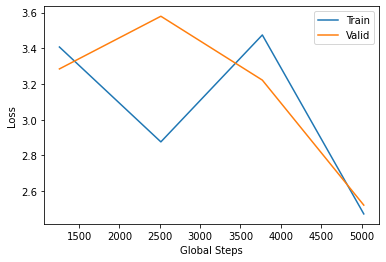

In [46]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(PATH + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [44]:
def evaluate(model, test_set=test_iter):
  y_pred = []
  y_true = []
  model.eval()
  with torch.no_grad():
    for (labels, titlebody), _ in tqdm(test_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        output = model(titlebody, labels)
        _, output = output
        y_pred.extend(torch.argmax(output, 1).tolist())
        y_true.extend(labels.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[0,1,2,3,4], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix')

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')

  ax.xaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])
  ax.yaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/316 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0000    0.0000    0.0000       136
           2     0.1973    0.0803    0.1142       361
           3     0.0000    0.0000    0.0000        46
           4     0.0000    0.0000    0.0000        90

   micro avg     0.1973    0.0458    0.0744       633
   macro avg     0.0395    0.0161    0.0228       633
weighted avg     0.1125    0.0458    0.0651       633



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

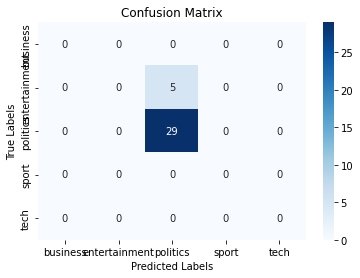

In [45]:
bert_model = BertModel().to(device)
load_model(PATH + '/model.pt', bert_model)
evaluate(bert_model, test_iter)